In [22]:
# Import all necesary libraries
import os
import glob

import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [6]:
def save_df(df, filename):
    filepath = f'./{filename}.csv'

    if os.path.exists(filepath):
        os.remove(filepath)

    df.to_csv(filepath, index=False)

## Note
I am providing the data as a tar file because I am developing this in google colab and it is easier to untar the data for use, this is all of the data I collected in PolicyMap

In [7]:
# Untar data folder
import tarfile
data_tar_path = './data.tar.gz'

# Set base directory for data folder
data_dir = './data/'

if os.path.exists(data_tar_path):
    with tarfile.open(data_tar_path, 'r:gz') as tar:
        tar.extractall('./')

/tmp/ipython-input-2025740193.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall('./')


# Data ingestion and cleaning

In [8]:
import os
import glob

def combine_csvs(data_dir='data'):
  csv_files = glob.glob(os.path.join(data_dir, '**', '*.csv'), recursive=True)

  dfs = []

  for csv_file in csv_files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Check if df is empty before proceeding
    if df.empty:
        print(f"Warning: {csv_file} is empty. Skipping.")
        continue

    first_col = df.columns[0]

    # Check if first_col exists in df before using it for filtering
    if first_col not in df.columns:
        print(f"Warning: First column '{first_col}' not found in {csv_file}. Skipping filter.")
    else:
      # Make sure 'GeoID' is consistent, case-insensitive and stripped
      # Check if 'GeoID' is actually a column header before trying to filter by it
      if 'GeoID' in df.columns or 'geoid' in df.columns:
         df = df[~df[first_col].astype(str).str.strip().str.lower().isin([first_col.lower(), 'geoid'])]
         df = df.reset_index(drop=True)

    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    # filename = os.path.basename(csv_file)
    # df['source_file'] = os.path.splitext(filename)[0]

    dfs.append(df)

  if not dfs:
    print("No CSV files found to concatenate.")
    return pd.DataFrame() # Return an empty DataFrame if no files were found

  combined_df = pd.concat(dfs, ignore_index=True)
  return combined_df

In [9]:
df = combine_csvs(data_dir)

# Header row is duplicated so remove the second one
df = df[df['geoid'] != 'GeoID']

# Clean up column names and drop redundant or not needed columns
columns_to_remove = ['geography_type_description',
                     'geography_name',
                     'formatted_geoid',
                     'geographic_vintage',
                     'data_source',
                     'selected_location',
                     'data_time_period']

df.drop(columns=columns_to_remove, inplace=True)
df['year'] = 2021

columns_renames = {
    'percent_of_people_who_drove_to_work': 'pct_drove_to_work',
    'avg._vehicles_per_household': 'avg_vehicles_per_household',
    'pct._of_people_walking_to_work': 'pct_walking_to_work',
    'pct._of_people_who_took_public_transit_to_work': 'pct_transit_to_work',
    'pct._of_people_who_rode_bike_to_work': 'pct_bike_to_work',
    'pedestrian-oriented_road_density': 'pedestrian_oriented_road_density',
    'national_walkability_index': 'national_walkability_index',
    'sits_in_state': 'state'
}

# These are to be more friendly for PowerBI
df = df.rename(columns={
    'jobs_within_45_minutes_auto_travel_time':'jobs_45m_auto',
    'pedestrian_oriented_road_density':'ped_oriented_rd_dens',
    'national_walkability_index':'walk_idx'
})

df.rename(columns=columns_renames, inplace=True)

In [10]:
agg_dict = {
    'state': 'first',
    'distance_to_transit': 'first',
    'jobs_45m_auto': 'first',
    'walk_idx': 'first',
    'road_network_density': 'first',
    'pedestrian_oriented_road_density': 'first',
    'avg_vehicles_per_household': 'first',
    'pct_drove_to_work': 'first',
    'pct_walking_to_work': 'first',
    'pct_transit_to_work': 'first',
    'population_density': 'first',
    'per_capita_income': 'first',
    'year': 'first'
}

numeric_cols = [
    'distance_to_transit', 'jobs_45m_auto',
    'walk_idx', 'road_network_density',
    'pedestrian_oriented_road_density',
    'avg_vehicles_per_household',
    'pct_drove_to_work', 'pct_walking_to_work',
    'pct_transit_to_work','population_density',
    'per_capita_income',
]

# Apply aggregation
df_consolidated = df.groupby('geoid', as_index=False).agg(agg_dict)

assert df_consolidated['geoid'].nunique() == len(df_consolidated), "Duplicate geoids found"

df = df_consolidated
print(df.columns)

Index(['geoid', 'state', 'distance_to_transit', 'jobs_45m_auto', 'walk_idx',
       'road_network_density', 'pedestrian_oriented_road_density',
       'avg_vehicles_per_household', 'pct_drove_to_work',
       'pct_walking_to_work', 'pct_transit_to_work', 'population_density',
       'per_capita_income', 'year'],
      dtype='object')


In [11]:
for col in numeric_cols:
    # Convert the column to numeric, coercing errors to NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')
    # Impute missing values with the median of the state group
    df[col] = df.groupby('state')[col].transform(lambda x: x.fillna(x.median()))

# It is easier for me to analyize vehicles per household if it is a whole number
df['avg_vehicles_per_household'] = df['avg_vehicles_per_household'].astype(int)

In [13]:
# Create quartiles for walkability index and per capita income
df['walkability_quartile'] = pd.qcut(df['walk_idx'], q=4, labels=False, duplicates='drop')
df['affordability_quartile'] = pd.qcut(df['per_capita_income'], q=4, labels=False, duplicates='drop')

# Combine quartiles to create a composite index (example: summing quartiles)
# You might want to weight these differently or use a different combination method
df['walkability_affordability_index'] = df['walkability_quartile'] + df['affordability_quartile']

display(df[['walk_idx', 'walkability_quartile', 'per_capita_income', 'affordability_quartile', 'walkability_affordability_index']].head())
save_df(df, 'rev5')

,walk_idx,walkability_quartile,per_capita_income,affordability_quartile,walkability_affordability_index
0,1.17,0,15959.0,0,0
1,1.33,0,11106.0,0,0
2,3.33,0,16217.0,0,0
3,2.33,0,22630.0,0,0
4,3.17,0,19653.0,0,0


In [16]:
# This is a composite walkability score
df['composite_walkability_score'] = (
    df['walk_idx'] * 0.4 + # Walkability index will be the primary score
    df['pct_walking_to_work'] * 0.3 + # Walking behavior
    df['pct_transit_to_work'] * 0.2 - # Public transit usage
    (df['pct_drove_to_work'] * 0.1) # Driving negatively correlates
)

# Define features and target
features = ['distance_to_transit', 'jobs_45m_auto', 'road_network_density',
            'pedestrian_oriented_road_density', 'avg_vehicles_per_household',
            'population_density', 'per_capita_income']
target = 'walk_idx'

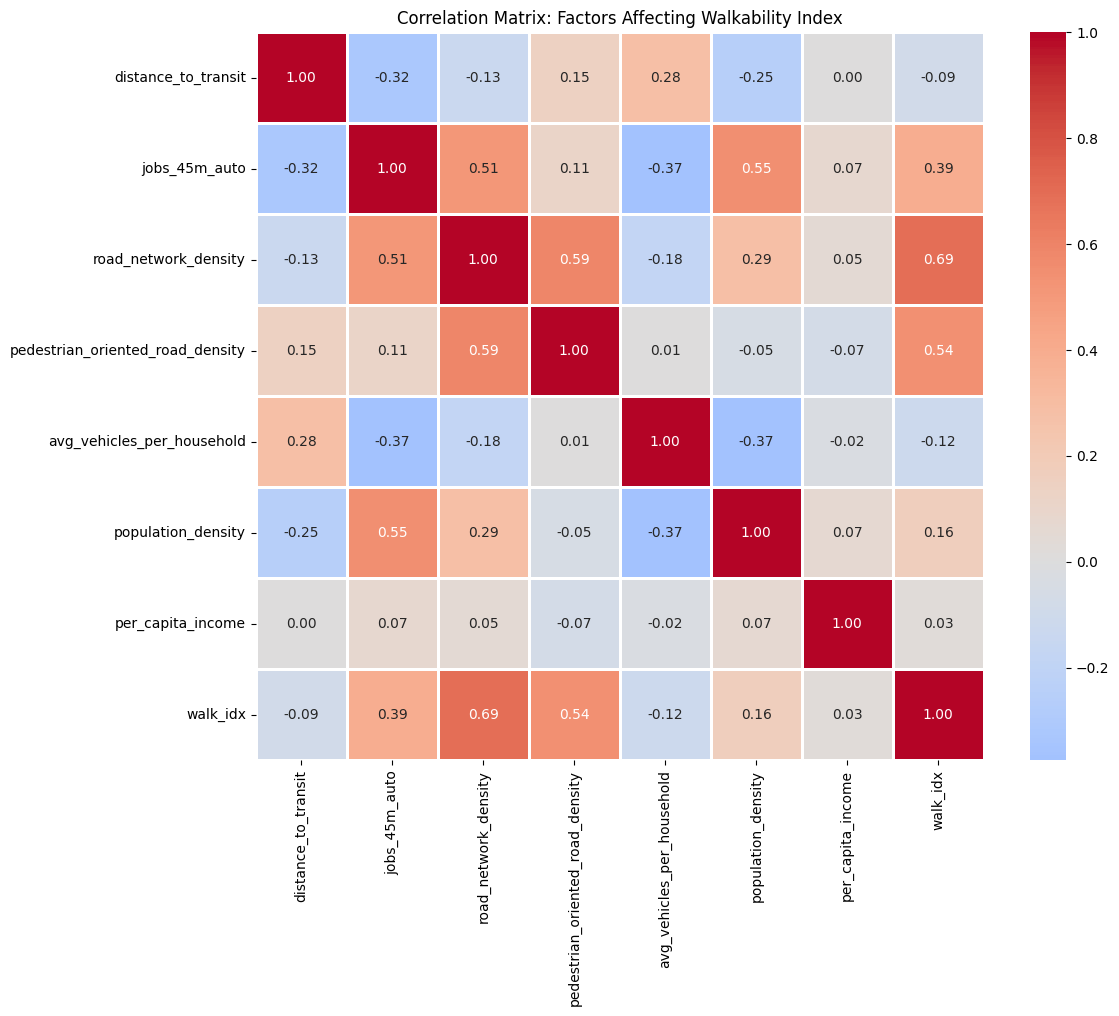

In [17]:
corr_data = df[features + [target]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1, center=0, square=True)
plt.title('Correlation Matrix: Factors Affecting Walkability Index')
plt.tight_layout()
plt.show()

In [18]:
print("Correlations with walkability index")
walk_correlations = corr_data[target].sort_values(ascending=False)
for feature, corr in walk_correlations.items():
  if feature != target:
    print(f"{feature:40s}: {corr:6.3f}")

Correlations with walkability index
road_network_density                    :  0.692
pedestrian_oriented_road_density        :  0.539
jobs_45m_auto                           :  0.392
population_density                      :  0.163
per_capita_income                       :  0.028
distance_to_transit                     : -0.087
avg_vehicles_per_household              : -0.120


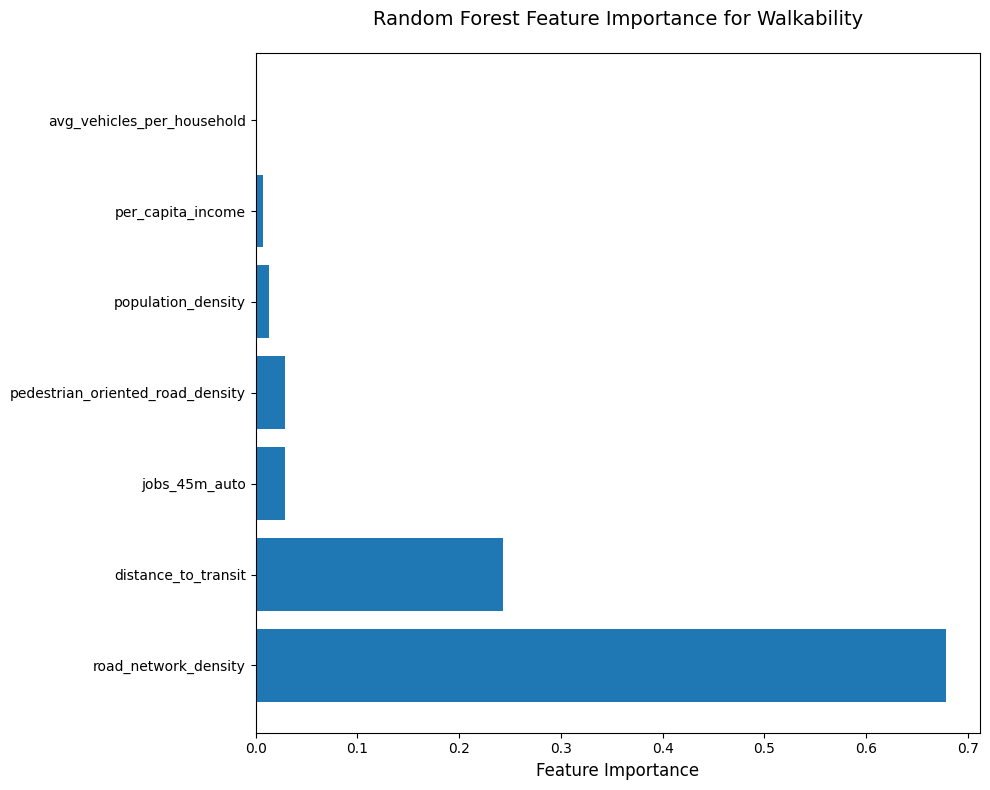

In [25]:
X = df[features].fillna(df[features].median())
y = df[target].fillna(df[target].median())

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X, y)

importance_df = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest Feature Importance for Walkability', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

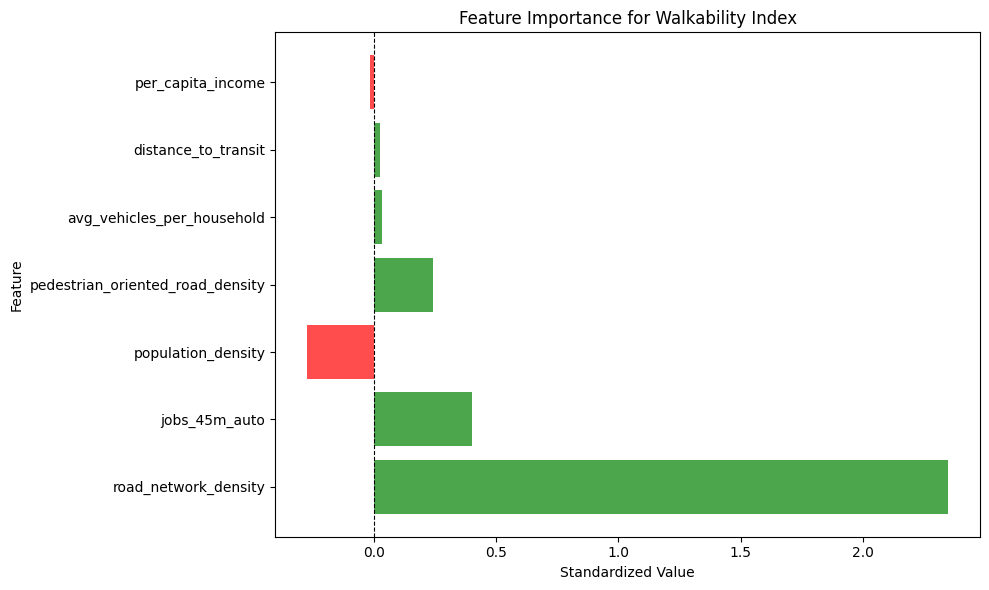

In [27]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=features)

# Fit linear regression model
lr_model = LinearRegression()
lr_model.fit(X_scaled_df, y)

# Get coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': lr_model.coef_
}).sort_values('coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in coef_df['coefficient']]
plt.barh(coef_df['feature'], coef_df['coefficient'], color=colors, alpha=0.7)
plt.xlabel('Standardized Value')
plt.ylabel('Feature')
plt.title('Feature Importance for Walkability Index')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

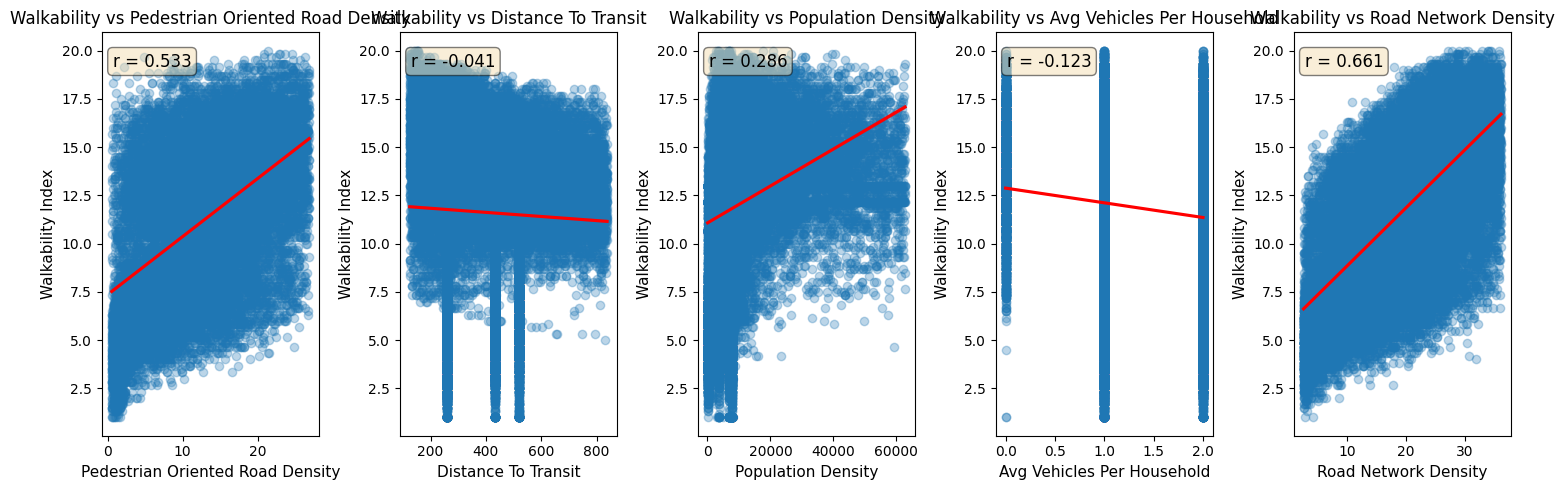

In [28]:
key_features = [
    'pedestrian_oriented_road_density',
    'distance_to_transit',
    'population_density',
    'avg_vehicles_per_household',
    'road_network_density'
]

fig, axes = plt.subplots(nrows=1, ncols=len(key_features), figsize=(15, 5))
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
  ax = axes[idx]

  # Remove outliers for bettwe visual
  q1 = df[feature].quantile(0.05)
  q3 = df[feature].quantile(0.95)
  mask = (df[feature] >= q1) & (df[feature] <= q3)

  sns.regplot(data=df[mask], x=feature, y=target, ax=ax,
              scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})


  # Calculate and display correlation
  corr = df[mask][[feature, target]].corr().iloc[0, 1]
  ax.text(0.05, 0.95, f'r = {corr:.3f}',
          transform=ax.transAxes, fontsize=12, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

  ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=11)
  ax.set_ylabel('Walkability Index', fontsize=11)
  ax.set_title(f'Walkability vs {feature.replace("_", " ").title()}', fontsize=12)

plt.tight_layout()
plt.savefig('key_relationships_scatter.png', dpi=300, bbox_inches='tight')
plt.show()